# Spacy test

## Import neccesary libraries

In [57]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import re
import numpy as np
from pprint import pprint
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
# use pre-trained corpus to help tokenise words
nlp = spacy.load('en_core_web_sm')

## Terms explained
Document -> a bunch of texts <br>
Corpus -> a bunch of documents <br>
Vectors -> a mathematically convenience representation of a document (a bunch of textx) <br>
Models -> an algorithm for transforming vectors from one representation to another <br>

# load data

In [8]:
movie = pd.read_csv('nMovieRg.csv', usecols=['title','description'])
tvshow = pd.read_csv('nTvshowRg.csv', usecols=['title','description'])

In [10]:
netflix_df = movie.append(tvshow, ignore_index=True)

### Each description is a "doc". The collection of these "docs" is the "corpus".

In [14]:
corpus = netflix_df.description.values.tolist() #list of docs

In [15]:
def tokenise(doc):
    """Use spacy as the nlp object to tokenise each doc"""
    return [token.text for token in nlp(doc)]

In [16]:
corpus_with_tkdocs = [tokenise(doc) for doc in corpus]

In [17]:
# mapping out the title and each description. so later on i can search 
title_text = dict(zip(netflix_df['title'].str.lower().tolist(), corpus_with_tkdocs))
# lower the title (easy for search)

### Use pre-trained google news model to train my w2v model
It might take a few seconds to train

In [18]:
path = "GoogleNews-vectors-negative300.bin"
w2v = KeyedVectors.load_word2vec_format(path, binary=True)

In [19]:
# this is one way to get each title's vector representation
# more investagtion is needed later.

def get_vectors(first_map, second_map):
    first_vec  = dict()
    for title, description in first_map.items():
        temp = list()
        for element in description:
            try:
                temp.append(second_map[element])
            except KeyError:
                pass
        first_vec[title] = np.mean(temp, axis=0)
    
    return first_vec

In [20]:
def get_most_similar(lookup_id, title_vec):

    sim = list()
    lookup_map = title_vec
    subject_map = title_vec 
        
    for uid, vec in lookup_map.items():
        thisSim = cosine_similarity(vec.reshape(1, -1), subject_map[lookup_id].reshape(1, -1))
        sim.append((uid, thisSim[0][0]))

    return sorted(sim, key=lambda x: x[1], reverse=True)

In [21]:
title_vec = get_vectors(title_text, w2v)

In [22]:
get_most_similar('house of cards', title_vec)[1:11]

[('bloodline', 0.9467709),
 ('reign', 0.9466064),
 ('broadchurch', 0.9440308),
 ('peaky blinders', 0.9435389),
 ('the end of the f***ing world', 0.9429343),
 ('hostages', 0.9425726),
 ('collateral', 0.9425075),
 ('breaking bad', 0.94222677),
 ('sherlock', 0.94206876),
 ('orange is the new black', 0.9417874)]

In [23]:
get_most_similar('black mirror', title_vec)[1:11]

[('between', 0.93673533),
 ('the mist', 0.9354942),
 ('nightflyers', 0.93453264),
 ('bloodline', 0.93113786),
 ('lovesick', 0.9277378),
 ('you', 0.9274123),
 ('containment', 0.9269811),
 ('galavant', 0.92679775),
 ('footprints', 0.92676425),
 ('quantico', 0.92660797)]

In [ ]:
def sim_title_description(title, dataset):
    """Return the title description"""
    filt = dataset['title'].str.lower() == title
    return dataset.loc[filt]['description'].values.tolist()[0]

In [ ]:
def dscp_comparison(org, dataset, vec):
    
    org = org.lower()
    org_dscp = dataset.loc[dataset['title'].str.lower() == org]['description'].values.tolist()[0]
    print(f"The input title name is '{org}'\n")
    print(org_dscp, '\n')
    sim = get_most_similar(org, vec)[1:11]
    
    for i in range(len(sim)):
        title = sim[i][0]
        print(f"The most similiar No.{i+1} is '{title}'\n")
        print(sim_title_description(title, dataset),'\n')

In [ ]:
title = "Star Wars: The Rise of Skywalker (Episode IX)".lower()
dscp_comparison(title, data6k, title_vec6k)

In [ ]:
title = ("Star Wars: The Rise of Skywalker (Episode IX)").lower()
sim = get_most_similar(title, title_vec6k)[1:11]
pprint(sim)

# Display scatterplot

In [28]:
def display_pca_scatterplot(titles, vec):
    
    title_vectors = np.array([vec[title] for title in titles])
    twodim = PCA().fit_transform(title_vectors)[:,:2]
    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='grey')
#     for title, (x,y) in zip(titles, twodim):
#         plt.text(x+0.05, y+0.05, title)
    plt.show()

In [31]:
# titles = np.random.choice(netflix_df['title'].values, size = 1000).tolist()
titles = netflix_df['title'].values.tolist()
titles = [title.lower() for title in titles]

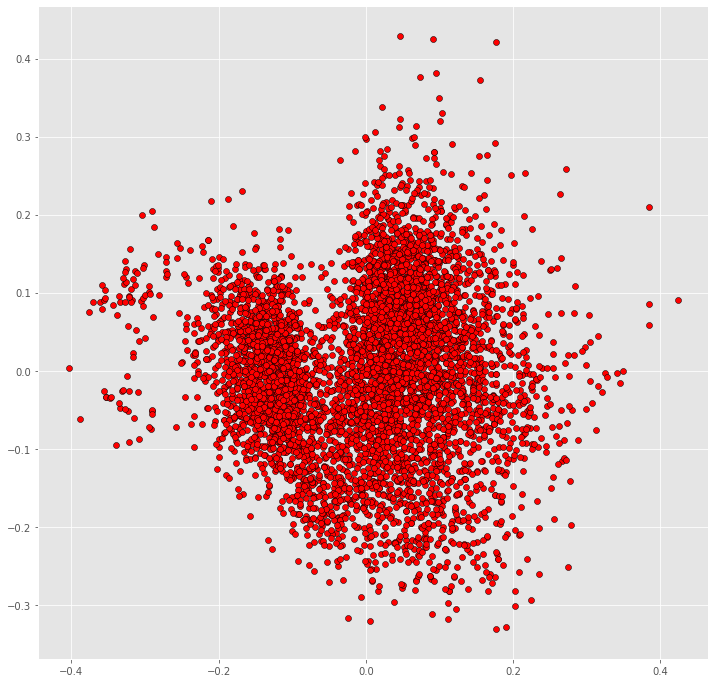

In [32]:
display_pca_scatterplot(titles, title_vec)

#  Try T-SNE

In [48]:
values = np.array(list(title_vec.values()))
labels = list(title_vec.keys())

In [49]:
tsne = TSNE(n_components=2, random_state=1)
tsne_values = tsne.fit_transform(values)

In [51]:
tsne_data = np.vstack((tsne_values.T, labels)).T

In [55]:
tsne_df = pd.DataFrame(data=tsne_data, columns=['Dim1','Dim2','Titles'])

In [64]:
tsne_df.head()

,Dim1,Dim2,Titles
0,4.85614,17.07938,inception
1,20.465414,-7.9267435,back to the future
2,2.94562,-26.741875,the matrix
3,1.3456188,-24.876501,"the good, the bad and the ugly"
4,-6.2959585,16.651255,avengers: infinity war


In [62]:
test = tsne_df.head(15)

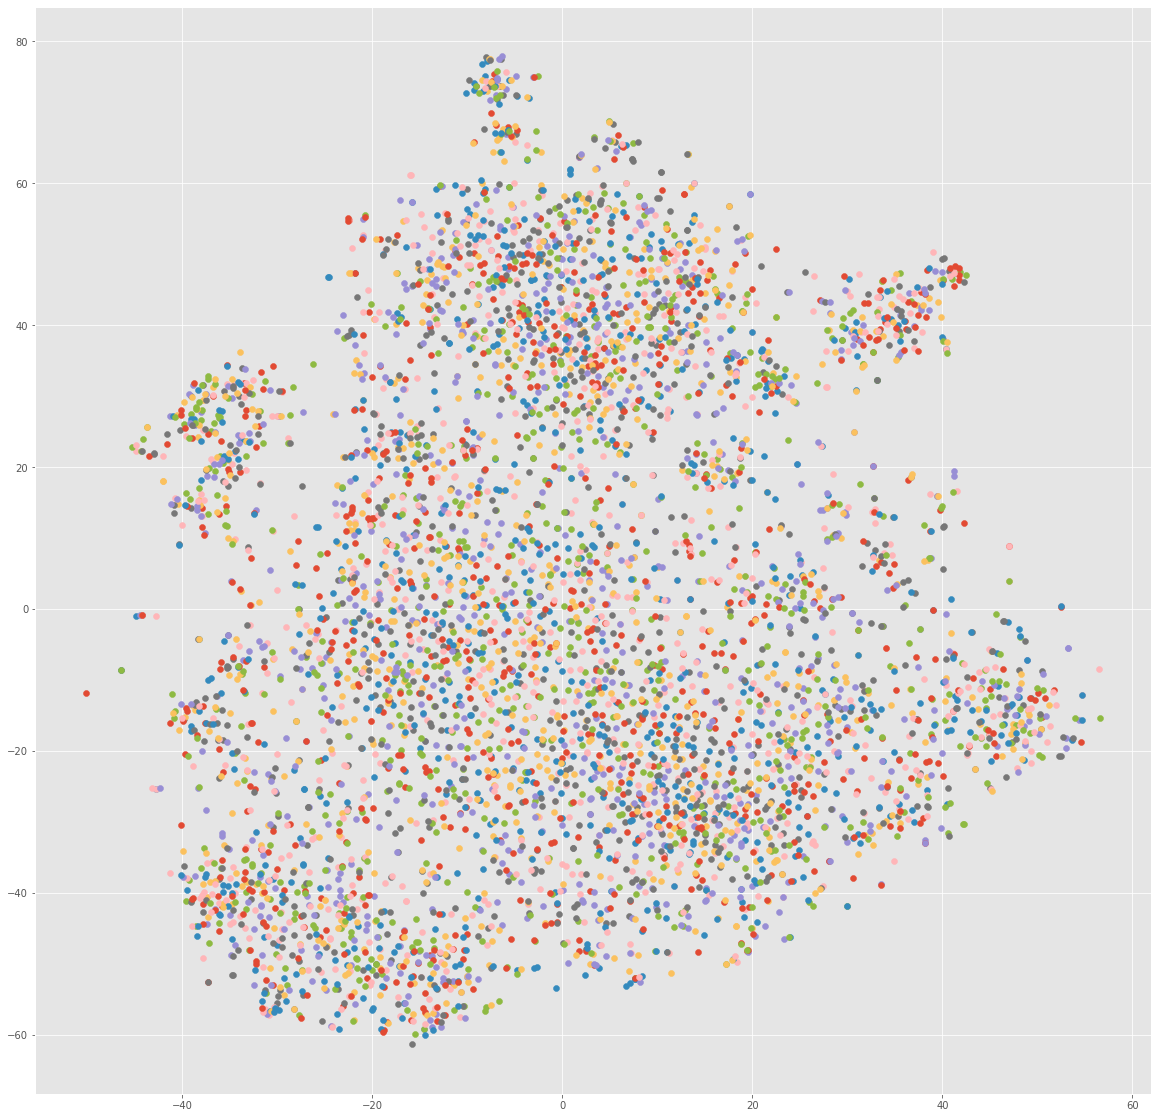

In [69]:
x, y = [], []
for item in tsne_values:
    x.append(item[0])
    y.append(item[1])
    
plt.figure(figsize=(20, 20))
for ix, _ in enumerate(x):
    plt.scatter(x[ix], y[ix])
plt.show()

# K-means

In [76]:
from sklearn.cluster import KMeans

In [81]:
kmean_df = tsne_df.drop('Titles',axis=1)

In [114]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(kmean_df)

KMeans(n_clusters=10)

In [115]:
labels = kmeans.predict(kmean_df)
centroids = kmeans.cluster_centers_

In [116]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

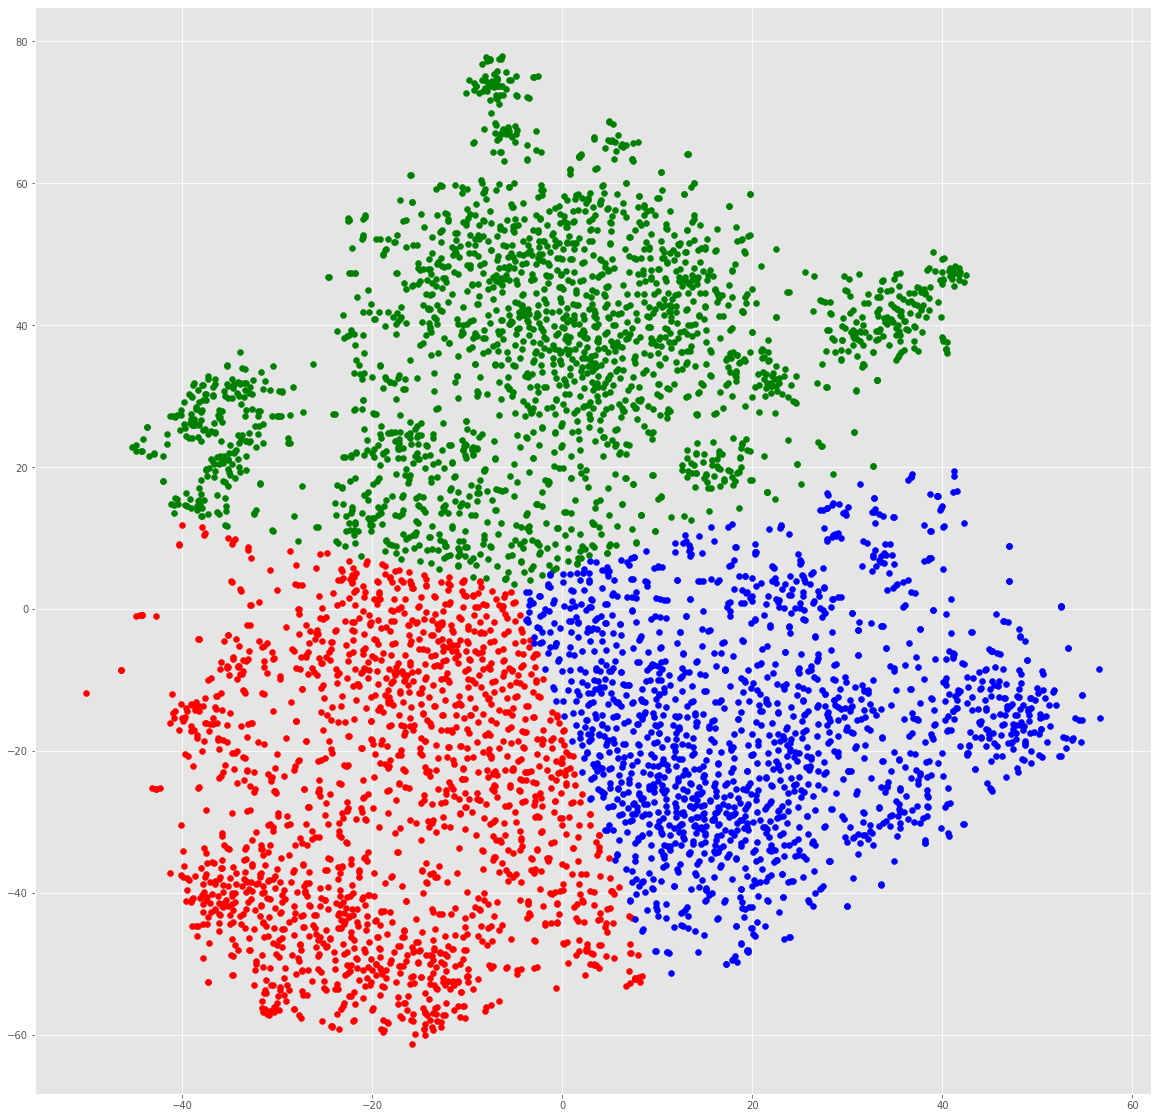

In [104]:
c = {
    '0':'r',
    '1':'g',
    '2':'b'
    }
color = list()
for label in labels:
    color.append(c[str(label)])

x, y = [], []
for item in tsne_values:
    x.append(item[0])
    y.append(item[1])
    
plt.figure(figsize=(20, 20))
for ix, _ in enumerate(x):
    plt.scatter(x[ix], y[ix], color=color[ix])
# plt.xlim(-60,60)
# plt.ylim(-70,90)
plt.show()

In [105]:
kmeans.inertia_

2854632.374099743

In [106]:
len(labels)

5585

In [108]:
wcss = []

for i in range(1,30):
    kmeans = KMeans(i)
    kmeans.fit(kmean_df)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

In [113]:
for i in range(1,30):
    print(wcss[i]-wcss[i-1])

-4533799.784832978
-1407053.0986978873
-837698.9009866577
-330621.9344925985
-280141.64257433824
-241530.0383723185
-165149.5580895011
-103285.0838306616
-93038.02655838907
-82216.93037489417
-57489.49643496983
-48421.437033688766
-43733.59201619215
-47979.54390547046
-34935.85116959852
-35179.847289289406
-31952.022348311206
-24953.477027618384
-18509.597836396657
-23853.74630864564
-15626.629368622089
-14568.848637147574
-12538.79343821446
-14977.072193585103
-9268.885588090925
-9772.314465664094
-12421.576665436383
-9565.029204225924


IndexError: list index out of range

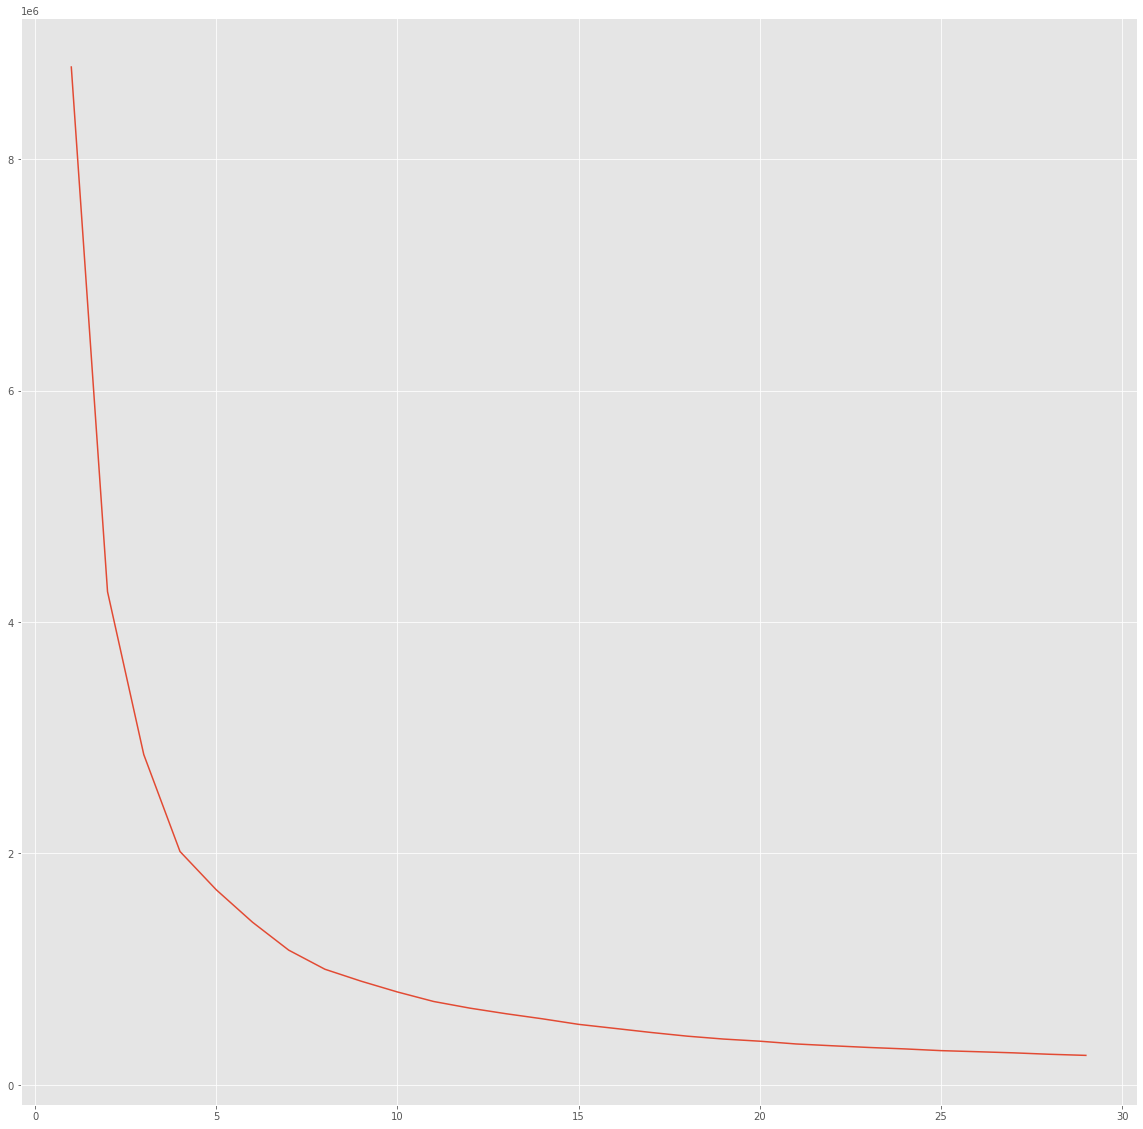

In [111]:
number_clusters = range(1,30)
plt.figure(figsize=(20,20))
plt.plot(number_clusters, wcss)
plt.show()